In [1]:
# ------------------------------------------------------------------------------------------------------------ #
### Path were the AccuraTools.jl file exists

#PATHFunctions = raw"C:\Users\Siby\Dropbox\git-repos\Hippocampus-HDMEA";
PATHFunctions = "/home/isabel/Dropbox/git-repos/Hippocampus-HDMEA";

push!( LOAD_PATH, PATHFunctions );
using AccuraTools

# ------------------------------------------------------------------------------------------------------------ #

In [2]:
# ------------------------------------------------------------------------------------------------------------ #
# Loading Variables and defining paths

using JLD 
using StatsBase
using Colors
using Plots

FILEBRW = "/home/isabel/Desktop/Misc/Data/Files_Chole/example2.brw";
#FILEBRW = raw"C:\Users\Siby\Desktop\Data\example2.brw"

PATHMain = split( FILEBRW, "." )[ 1 ];
PATHVoltage = joinpath( PATHMain, "Voltage" );
PATHInfo = joinpath( PATHMain, "Info" );
PATHFigures = joinpath( PATHMain, "Figures" ); mkpath( PATHFigures );
FILEVars = joinpath( PATHInfo, "Variables.jld" ); 

Variables = load( FILEVars )[ "Variables" ];
FILESVoltage = searchdir( PATHVoltage, ".jld" );

# ------------------------------------------------------------------------------------------------------------ #

In [3]:
# ------------------------------------------------------------------------------------------------------------ #
# for i = 1:length( FILESVoltage )
i = 1
FILEVoltage = FILESVoltage[ i ];
aux = load( FILEVoltage ); data = aux[ "data" ]; DiscartedChannels = aux[ "DiscartedChannels" ];

# ------------------------------------------------------------------------------------------------------------ #

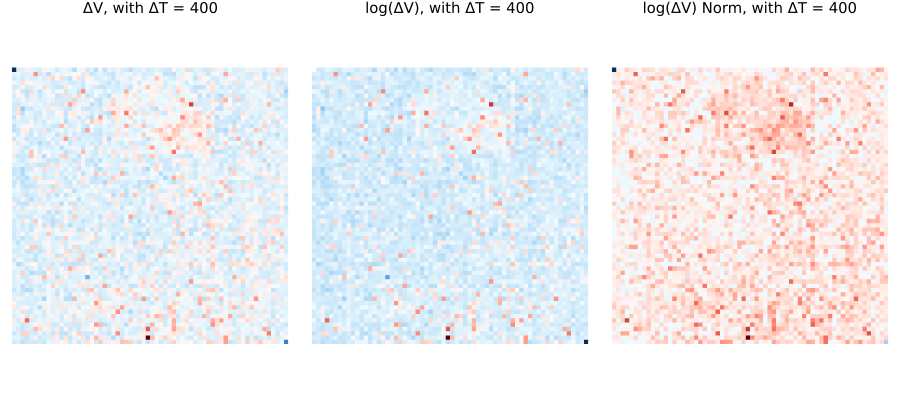

In [6]:
# ACD-01 
ΔT = 400; # ms
lims = [ 100, 1200 ]; # channels
ΔV01 = ΔV( Variables, data, ΔT );
ΔV01[ DiscartedChannels ] .= 0;
#
ΔV01log = log.( ΔV01 );
ΔV01log0 = copy( ΔV01log ); ΔV01log0[ ΔV01log0 .== -Inf ] .= 0;

cm = reverse(colormap( "RdBu", length( countmap( ΔV01 ) ); mid = 0.5, logscale = false ) );
P1 = Zplot( ΔV01, "W", cm ); P1 = title!( "ΔV, with ΔT = $ΔT" )
cm = reverse(colormap( "RdBu", length( countmap( ΔV01log ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( ΔV01log, "W", cm ); P2 = title!( "log(ΔV), with ΔT = $ΔT" )
cm = reverse(colormap( "RdBu", length( countmap( ΔV01log0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( ΔV01log0, "W", cm ); P3 = title!( "log(ΔV) Norm, with ΔT = $ΔT" )
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 10 )

FILEFigure = joinpath( PATHFigures, "DeltaT.png" );
savefig( F1, FILEFigure )
F1

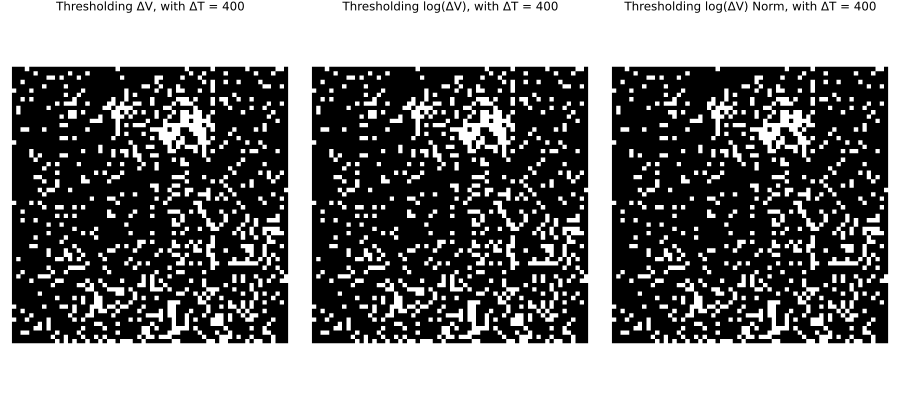

In [7]:
TΔV01, tΔV01 = Thresholding( ΔV01 );
aux = vec( sum( TΔV01, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TΔV01[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTΔV01 = findall( aux .== maximum( aux ) );

TΔV01log, tΔV01log = Thresholding( ΔV01log );
aux = vec( sum( TΔV01log, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TΔV01log[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTΔV01log = findall( aux .== maximum( aux ) );

TΔV01log0, tΔV01log0 = Thresholding( ΔV01log0 );
aux = vec( sum( TΔV01log0, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TΔV01log0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTΔV01log0 = findall( aux .== maximum( aux ) );

P1 = Zplot( SelectedChannelsTΔV01, "0" ); P1 = title!( "Thresholding ΔV, with ΔT = $ΔT" );
P2 = Zplot( SelectedChannelsTΔV01log, "0" ); P2 = title!( "Thresholding log(ΔV), with ΔT = $ΔT" );
P3 = Zplot( SelectedChannelsTΔV01log0, "0" ); P3 = title!( "Thresholding log(ΔV) Norm, with ΔT = $ΔT" );
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 )

FILEFigure = joinpath( PATHFigures, "SelectedChannelsDeltaT.png" );
savefig( F1, FILEFigure );
F1

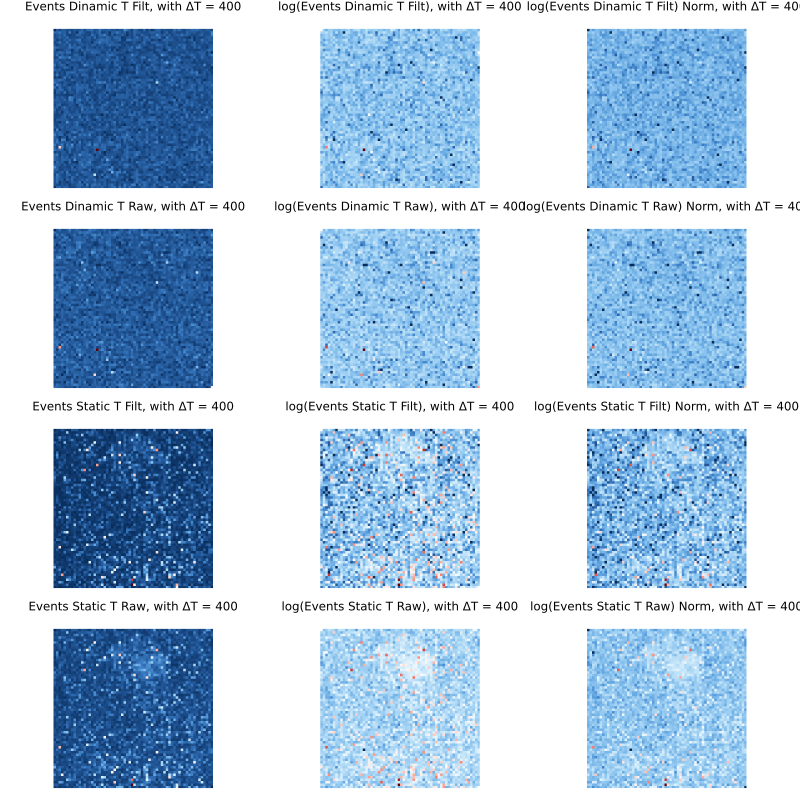

In [9]:
# ACD-02 Event detection
#
window = 5 # ms
bit = 1 # ms
distance = 0.4 # ms
σ = 4; # 4 / sqrt( 3 );
#
nChs = size( data, 1 );
channels = collect( 1:nChs );

ValidChannels = setdiff( channels, DiscartedChannels );
datafilt = FilteringMatrix( data, Variables );

window = ms2frames( window, Variables );
bit = ms2frames( bit, Variables );
distance = ms2frames( distance, Variables );
parameters = Dict(
    "window"    => window,
    "bit"      => bit,
    "distance"  => distance,
    "cte"       => σ
);

TotalBoth = zeros( Int, nChs );
EventsFilt = [ ]
EventsRaw = [ ]
Both = [ ]
ThrsFilt = [ ]
ThrsRaw = [ ]

for i in channels
    channelfilt = datafilt[ i, : ];
    channelraw = data[ i, : ];
    thrsFilt, IndexFilt = STExChannel( channelfilt, parameters );
    thrsRaw, IndexRaw = STExChannel( channelraw, parameters );
    TotalBoth[ i ] = length( intersect( IndexFilt, IndexRaw ) );
    EventsFilt = push!( EventsFilt, IndexFilt );
    ThrsFilt = push!( ThrsFilt, thrsFilt );
    EventsRaw = push!( EventsRaw, IndexRaw );
    ThrsRaw = push!( ThrsRaw, thrsRaw );
end

DTEFilt = length.( EventsFilt );
DTERaw = length.( EventsRaw );

DTEFiltlog = log.( DTEFilt );
DTEFiltlog0 = copy( DTEFiltlog ); DTEFiltlog0[ DTEFiltlog0 .== -Inf ] .= 0;

DTERawlog = log.( DTERaw );
DTERawlog0 = copy( DTERawlog ); DTERawlog0[ DTERawlog0 .== -Inf ] .= 0;

thr = -60;
STERaw = zeros( Int, nChs );
STEFilt = zeros( Int, nChs );
indexRaw = [ ];
indexFilt = [ ]
for i in channels
    channel = data[ i, : ]
    index = StaticThresholdEvents( channel, thr, parameters );
    if !isempty( index )
        STERaw[ i ] = length( index );
        push!( indexRaw, index );
    end
    channel = datafilt[ i, : ];
    index = StaticThresholdEvents( channel, thr, parameters );
    if !isempty( index )
        STEFilt[ i ] = length( index );
        push!( indexFilt, index );
    end
end

STEFiltlog = log.( STEFilt );
STEFiltlog0 = copy( STEFiltlog ); STEFiltlog0[ STEFiltlog0 .== -Inf ] .= 0;

STERawlog = log.( STERaw );
STERawlog0 = copy( STERawlog ); STERawlog0[ STERawlog0 .== -Inf ] .= 0;

cm = reverse( colormap( "RdBu", length(unique(DTEFilt)); mid = 0.6, logscale = false ) );
P1 = Zplot( DTEFilt, "W", cm ); P1 = title!( "Events Dinamic T Filt, with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( DTEFiltlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( DTEFiltlog, "W", cm ); P2 = title!( "log(Events Dinamic T Filt), with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( DTEFiltlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( DTEFiltlog0, "W", cm ); P3 = title!( "log(Events Dinamic T Filt) Norm, with ΔT = $ΔT" )

plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

cm = reverse( colormap( "RdBu", length( unique( DTERaw ) ); mid = 0.6, logscale = false ) );
P1 = Zplot( DTERaw, "W", cm ); P1 = title!( "Events Dinamic T Raw, with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( DTERawlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( DTERawlog, "W", cm ); P2 = title!( "log(Events Dinamic T Raw), with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( DTERawlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( DTERawlog0, "W", cm ); P3 = title!( "log(Events Dinamic T Raw) Norm, with ΔT = $ΔT" )

plot( )
F2 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

cm = reverse( colormap( "RdBu", length( unique( STEFilt ) ); mid = 0.6, logscale = false ) );
P1 = Zplot( STEFilt, "W", cm ); P1 = title!( "Events Static T Filt, with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( STEFiltlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( STEFiltlog, "W", cm ); P2 = title!( "log(Events Static T Filt), with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( STEFiltlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( STEFiltlog0, "W", cm ); P3 = title!( "log(Events Static T Filt) Norm, with ΔT = $ΔT" )

plot( )
F3 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

cm = reverse( colormap( "RdBu", length( unique( STERaw ) ); mid = 0.6, logscale = false ) );
P1 = Zplot( STERaw, "W", cm ); P1 = title!( "Events Static T Raw, with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( STERawlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( STERawlog, "W", cm ); P2 = title!( "log(Events Static T Raw), with ΔT = $ΔT" )
cm = reverse( colormap( "RdBu", length( countmap( STERawlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( STERawlog0, "W", cm ); P3 = title!( "log(Events Static T Raw) Norm, with ΔT = $ΔT" )

plot( )
F4 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

FT = plot( F1, F2, F3, F4, layout = ( 4, 1 ), wsize = (800, 800) );

FILEFigure = joinpath( PATHFigures, "EventDetection.png" );
savefig( FT, FILEFigure )
FT

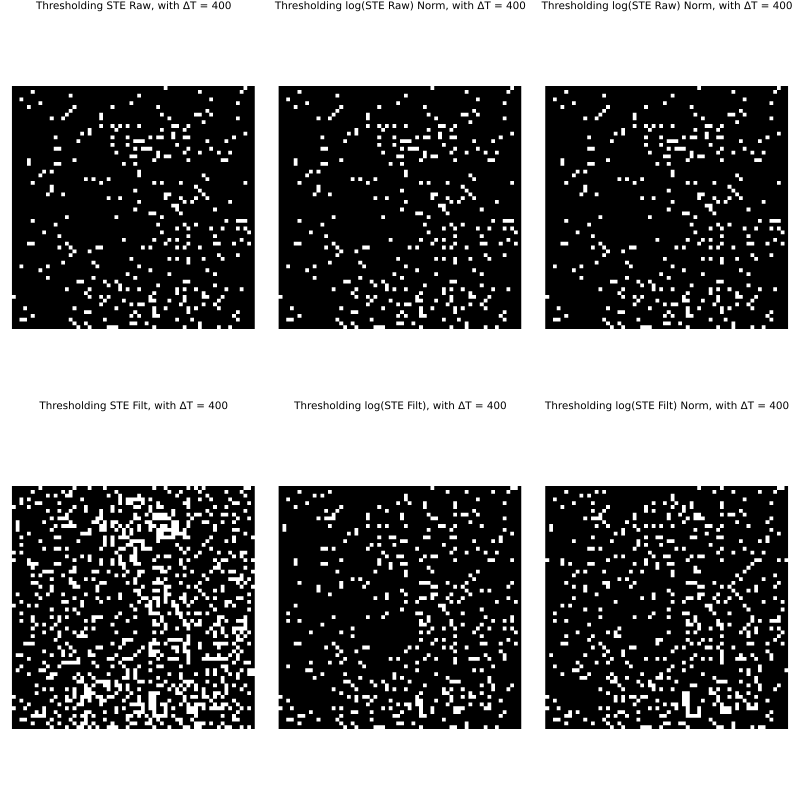

In [10]:
TSTERaw, tSTERaw = Thresholding( STERaw );
aux = vec( sum( TSTERaw, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTERaw[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTERaw = findall( aux .== maximum( aux ) );

TSTERawlog, tSTERawlog = Thresholding( STERawlog );
aux = vec( sum( TSTERawlog, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTERawlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTERawlog = findall( aux .== maximum( aux ) );

TSTERawlog0, tSTERawlog0 = Thresholding( STERawlog0 );
aux = vec( sum( TSTERawlog0, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTERawlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTERawlog0 = findall( aux .== maximum( aux ) );

TSTEFilt, tSTEFilt = Thresholding( STEFilt );
aux = vec( sum( TSTEFilt, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTEFilt[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTEFilt = findall( aux .== maximum( aux ) );

TSTEFiltlog, tSTEFiltlog = Thresholding( STEFiltlog );
aux = vec( sum( TSTEFiltlog, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTEFiltlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTEFiltlog = findall( aux .== maximum( aux ) );

TSTEFiltlog0, tSTEFiltlog0 = Thresholding( STEFiltlog0 );
aux = vec( sum( TSTEFiltlog0, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTEFiltlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTEFiltlog0 = findall( aux .== maximum( aux ) );

P1 = Zplot( SelectedChannelsTSTERaw, "0" ); P1 = title!( "Thresholding STE Raw, with ΔT = $ΔT" );
P2 = Zplot( SelectedChannelsTSTERawlog, "0" ); P2 = title!( "Thresholding log(STE Raw), with ΔT = $ΔT" );
P3 = Zplot( SelectedChannelsTSTERawlog0, "0" ); P2 = title!( "Thresholding log(STE Raw) Norm, with ΔT = $ΔT" );
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

P1 = Zplot( SelectedChannelsTSTEFilt, "0" ); P1 = title!( "Thresholding STE Filt, with ΔT = $ΔT" );
P2 = Zplot( SelectedChannelsTSTEFiltlog, "0" ); P2 = title!( "Thresholding log(STE Filt), with ΔT = $ΔT" );
P3 = Zplot( SelectedChannelsTSTEFiltlog0, "0" ); P3 = title!( "Thresholding log(STE Filt) Norm, with ΔT = $ΔT" );
plot( )
F2 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

FT = plot( F1, F2, wsize = ( 800, 800 ), layout = ( 2, 1 ), cbar = :none, titlefont = 7 );

FILEFigure = joinpath( PATHFigures, "SelectedChannelsEventDetection.png" );
savefig( FT, FILEFigure )
FT

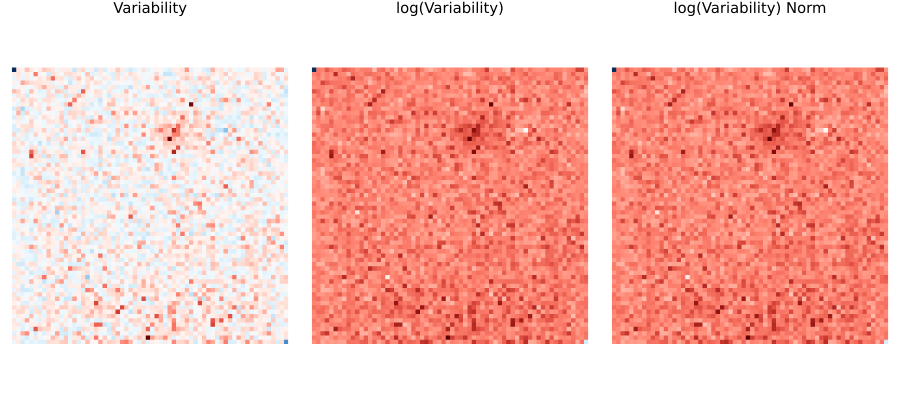

In [14]:
# ACD 03. 
V = zeros( Int, nChs ); # preallocation
[ V[ k ] = length( unique( data[ k, : ] ) ) for k in channels ];
#
Vlog = log.( V );
Vlog0 = copy( Vlog ); Vlog0[ Vlog0 .== -Inf ] .= 0;

cm = reverse( colormap( "RdBu", length( countmap( V ) ); mid = 0.4, logscale = false ) );
P1 = Zplot( V, "W", cm ); P1 = title!( "Variability" )
cm = reverse(colormap( "RdBu", length( countmap( Vlog ) ); mid = 0.2, logscale = false ) );
P2 = Zplot( Vlog, "W", cm ); P2 = title!( "log(Variability)" )
cm = reverse(colormap( "RdBu", length( countmap( Vlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( Vlog0, "W", cm ); P3 = title!( "log(Variability) Norm" )
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 10 )

FILEFigure = joinpath( PATHFigures, "Variability.png" );
savefig( F1, FILEFigure )
F1

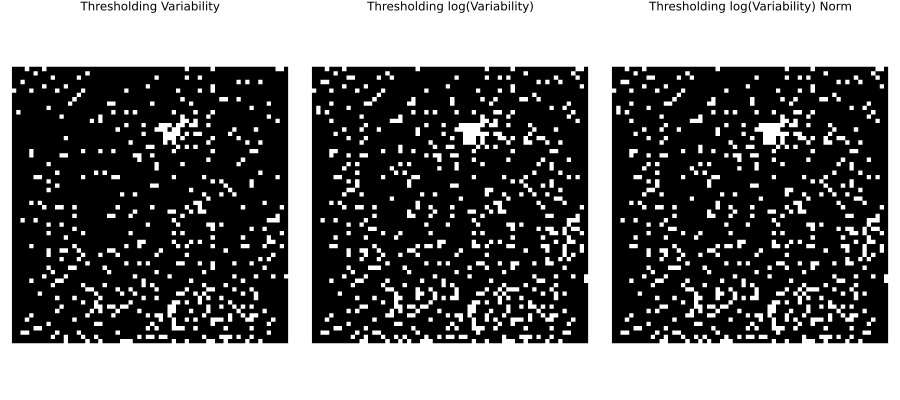

In [15]:
TV, tV = Thresholding( V );
aux = vec( sum( TV, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TV[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTV = findall( aux .== maximum( aux ) );

TVlog, tVlog = Thresholding( Vlog );
aux = vec( sum( TVlog, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TVlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTVlog = findall( aux .== maximum( aux ) );

TVlog0, tVlog0 = Thresholding( Vlog0 );
aux = vec( sum( TVlog0, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TVlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTVlog0 = findall( aux .== maximum( aux ) );

P1 = Zplot( SelectedChannelsTV, "0" ); P1 = title!( "Thresholding Variability" );
P2 = Zplot( SelectedChannelsTVlog, "0" ); P2 = title!( "Thresholding log(Variability)" );
P3 = Zplot( SelectedChannelsTVlog0, "0" ); P3 = title!( "Thresholding log(Variability) Norm" );
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 )

FILEFigure = joinpath( PATHFigures, "SelectedChannelsVariability.png" );
savefig( F1, FILEFigure );
F1

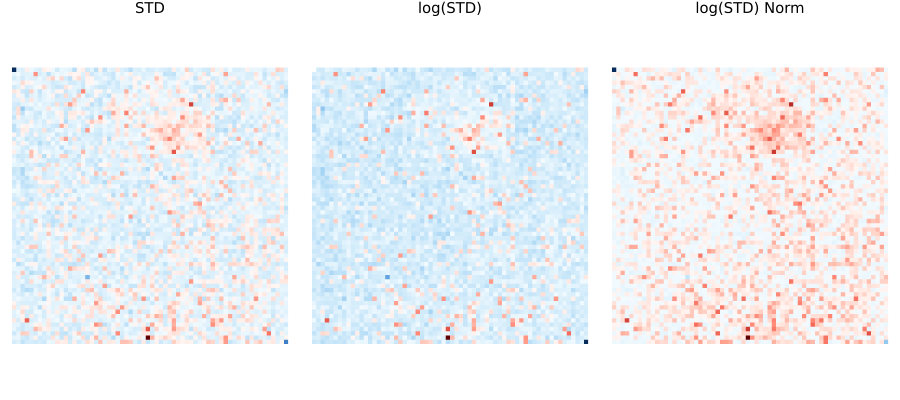

In [16]:
# ACD 04.
STD = zeros( Float64, nChs ); # preallocation
[ STD[ k ] = std( data[ k, : ] ) for k in channels ];
#
STDlog = log.( STD );
STDlog0 = copy( STDlog ); STDlog0[ STDlog0 .== -Inf ] .= 0;

cm = reverse(colormap( "RdBu", length( countmap( STD ) ); mid = 0.5, logscale = false ) );
P1 = Zplot( STD, "W", cm ); P1 = title!( "STD" )
cm = reverse(colormap( "RdBu", length( countmap( STDlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( STDlog, "W", cm ); P2 = title!( "log(STD)" )
cm = reverse(colormap( "RdBu", length( countmap( STDlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( STDlog0, "W", cm ); P3 = title!( "log(STD) Norm" )
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 10 )

FILEFigure = joinpath( PATHFigures, "STD.png" );
savefig( F1, FILEFigure )
F1

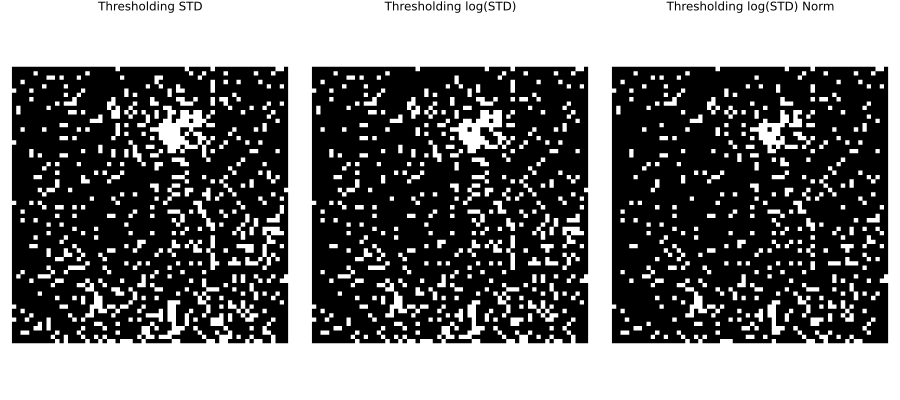

In [17]:
TSTD, tSTD = Thresholding( STD );
aux = vec( sum( TSTD, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTD[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTD = findall( aux .== maximum( aux ) );

TSTDlog, tSTDlog = Thresholding( STDlog );
aux = vec( sum( TSTDlog, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTDlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTDlog = findall( aux .== maximum( aux ) );

TSTDlog0, tSTDlog0 = Thresholding( STDlog0 );
aux = vec( sum( TSTDlog0, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTDlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ];
aux = sum( NewT, dims = 2 );
SelectedChannelsTSTDlog0 = findall( aux .== maximum( aux ) );

P1 = Zplot( SelectedChannelsTSTD, "0" ); P1 = title!( "Thresholding STD" );
P2 = Zplot( SelectedChannelsTSTDlog, "0" ); P2 = title!( "Thresholding log(STD)" );
P3 = Zplot( SelectedChannelsTSTDlog0, "0" ); P3 = title!( "Thresholding log(STD) Norm" );
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 )

FILEFigure = joinpath( PATHFigures, "SelectedChannelsSTD.png" );
savefig( F1, FILEFigure );
F1

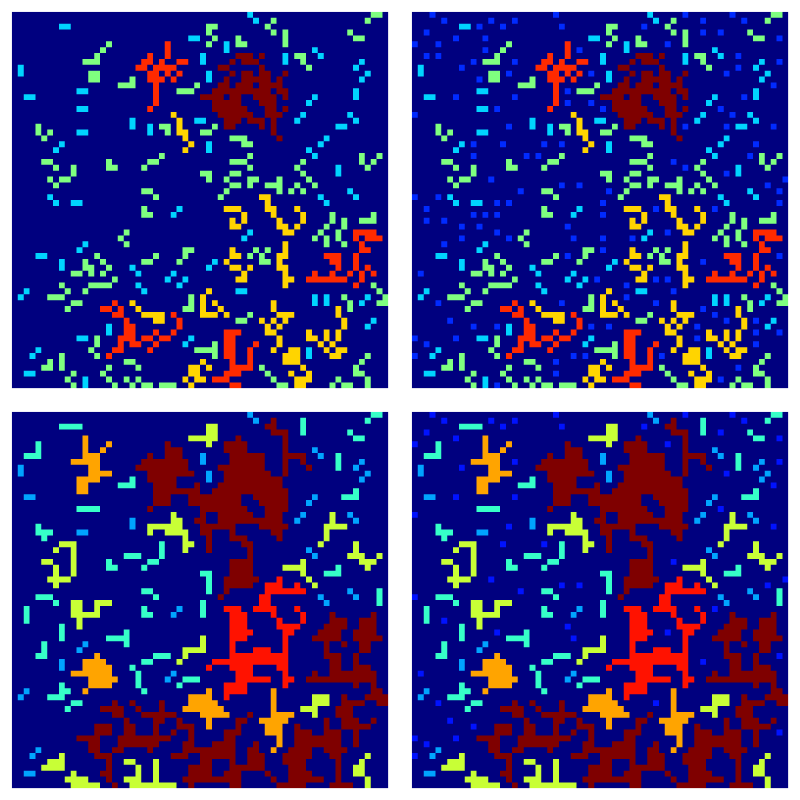

In [19]:
Seleccion = union( getindex.( SelectedChannelsTSTDlog,[ 1 ] ), getindex.( SelectedChannelsTΔV01log, [ 1 ] ) );
groups, loose = Get_Groups( Seleccion );

cm = :jet
F1 = FigureGroups( groups, [], cm);
F2 = FigureGroups( groups, loose, cm );

SeleccionFilled = FillingHolesCrux( Seleccion );

groupsfilled, loosefilled = Get_Groups( SeleccionFilled );
F3 = FigureGroups( groupsfilled, [], cm );
F4 = FigureGroups( groupsfilled, loosefilled, cm );

FT = plot( F1, F2, F3, F4, layout = ( 2,2 ), wsize = ( 800, 800 ) );

FILEFigure = joinpath( PATHFigures, "SelectedChannelsGroups.png" );
savefig( FT, FILEFigure );
FT

In [30]:
FinalSelection = vcat( groups... );

In [31]:
FinalSelection

692-element Vector{Int64}:
   41
  106
   62
   63
  125
  109
  172
  237
  137
  138
  162
  163
  226
    ⋮
 3988
 3990
 4053
 4055
 4056
 4024
 4087
 4089
 4090
 4058
 4059
 4060

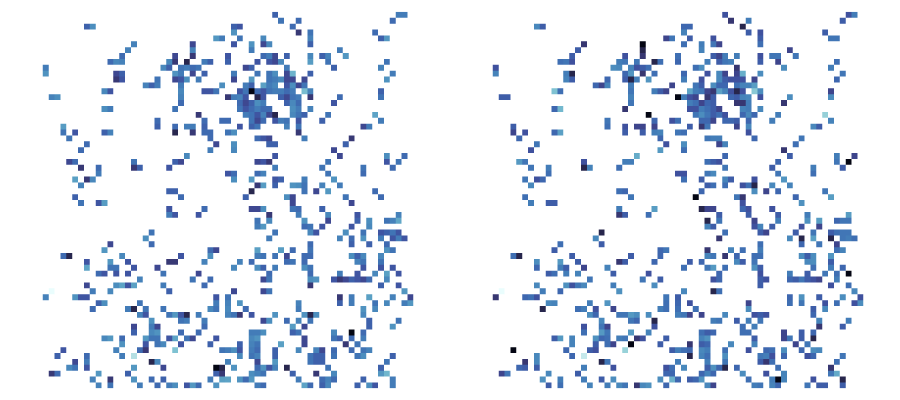

In [32]:
W1 = zeros( Int, nChs );
W1[ FinalSelection ] .= length.( EventsFilt[ FinalSelection ] );

W2 = zeros( Int, nChs );
W2[ FinalSelection ] .= length.( EventsRaw[ FinalSelection ] );

F1 = plot( Zplot( log.( W1 ), "W", :ice ), Zplot( log.( W2 ), "W", :ice ), cbar = :none, wsize = ( 900, 400 ) );

savefig( F1, joinpath( PATHFigures, "SelectionsEventsFinal.png") )
F1

In [33]:
findall(W1 .== maximum(W1))

1-element Vector{Int64}:
 3011

In [34]:
findall(W2 .== maximum(W2))

1-element Vector{Int64}:
 3011

In [27]:
channel = 3011;

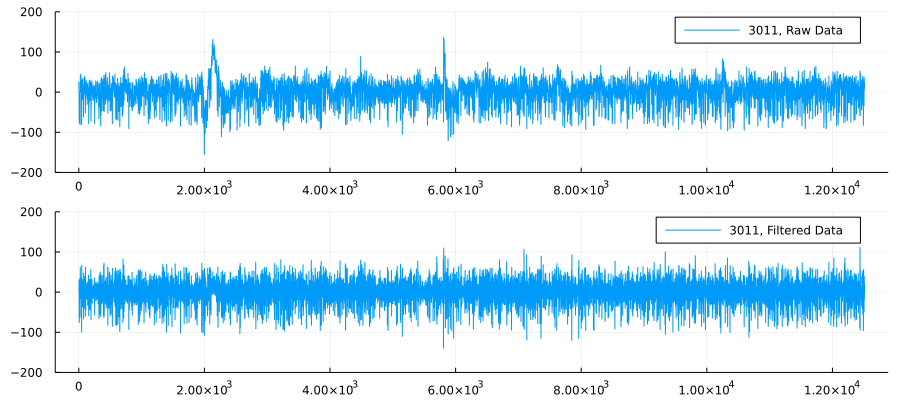

In [29]:
P1 = plot( data[channel,:], lab = "$channel, Raw Data", wsize=(900,400), ylims=(-200,200));
P2 = plot( datafilt[channel,:], lab = "$channel, Filtered Data", wsize=(900,400), ylims=(-200,200));
F1 = plot( P1,P2, layout = ( 2, 1 ), wsize=(900,400) );
savefig( F1, joinpath( PATHFigures, "MostspikesChannel.png" ) )
F1

In [35]:
w_pre = 1 #ms
w_post = 2 #ms
parameters[ "w_pre" ] = ms2frames( w_pre, Variables );
parameters[ "w_post" ] = ms2frames( w_post, Variables );

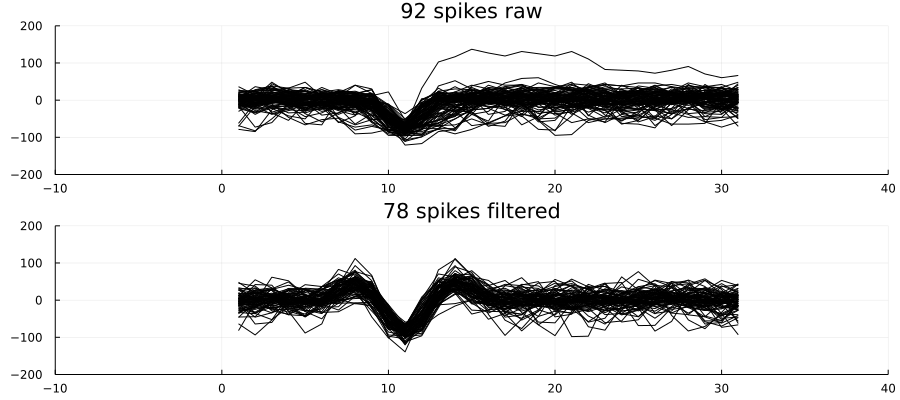

In [37]:
channelRaw = data[ channel, : ];
index_Raw = Int.( EventsRaw[ channel ] );

channelFilt = datafilt[ channel, : ];
index_Filt = Int.( EventsFilt[ channel ] );

SpikesRaw = Cut_Spikes( index_Raw, channelRaw, parameters );
SpikesFilt = Cut_Spikes( index_Filt, channelFilt, parameters );

P1 = plot(SpikesRaw', title = string(size(SpikesRaw,1), " spikes raw"), wsize = (900,400), ylims = (-200,200));
P2 = plot(SpikesFilt', title = string(size(SpikesFilt,1)," spikes filtered"), wsize = (900,400), ylims = (-200,200));

F1 = plot(P1, P2, layout = (2,1), xlims = (-10, 40), lc=:black, leg=:none, wsize = (900,400));
savefig( F1, joinpath( PATHFigures, "SpikesActiveChannel.png") );
F1

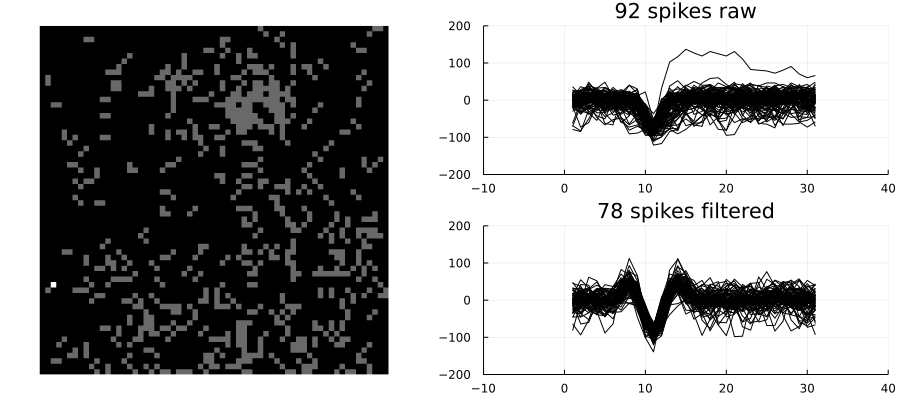

In [38]:
Z = zeros( Int, nChs); fill!(Z, 1);
Z[ FinalSelection ] .= 5;
Z[ channel ] = 10;

P3 = Zplot( Z, "W");
F2 = plot( P3, F1, layout = (1,2), wsize= (900,400), cbar = :none);
savefig( F2, joinpath( PATHFigures, "SpikesActiveChannelv02.png") );
F2

In [39]:
Variables[ "SelectedChannels" ] = FinalSelection;
save( FILEVars, "Variables", Variables );

In [40]:
Time = size(data,2)/Variables["SamplingRate"];

In [41]:
SpikeFrecuencyFilt = size(SpikesFilt,1)/Time # Hz

61.57266945607217

In [42]:
SpikeFrecuencyRaw = size(SpikesRaw,1)/Time # Hz

72.62417423023896